In [1]:

import torch.nn as nn
import torchvision
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim

C:\Users\Will_\miniconda3\envs\csc413\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **Step1 Load the data**

In [2]:
import dataloader
creature_imgs, creature_captions =dataloader.get_torch_creature_data() 

## **Step2 Process the data**
Turn both the image and captions in to embeddings,\
For images we are using **VGG16** to obtain the features
For captions we are using **GloVe** embeddings

* GloVe embedding

In [3]:
# creature_tokens = [i.replace(".", " . ").replace(",", " , ").replace(";", " ; ").replace("?", " ? ").lower().split() for i in creature_captions]


        Load glove embedding

In [4]:
# glove = torchtext.vocab.GloVe(name="6B", dim=50)

In [5]:
# for i in glove.stoi.keys():
#     if "<" in i:
#         print(i)

        Get the mean of all embedding vectors, we will use this mean as the embedding of all unseen words

In [6]:
# mean = glove.vectors.mean(dim=0)
# glove_vector_with_unk = torch.cat((glove.vectors,mean.unsqueeze(0)))

In [7]:
# vocab_size = len(glove_vector_with_unk)

        Get the vector representation of all sentences

In [8]:
## obtain the index of all words in the caption
# emb_creature_captions =[] 
# for caption in creature_tokens:
#     emb_creature_captions.append(torch.Tensor([glove.stoi[i] if i in glove.stoi.keys() else 400000 for i in caption]).int())

In [9]:
## pad the captions
# from torch.nn.utils.rnn import pad_sequence
# padded_emb_creature_captions = pad_sequence(emb_creature_captions,batch_first=True)


In [10]:
## obtain the embedding
# glove_emb = nn.Embedding.from_pretrained(glove_vector_with_unk)
# target = glove_emb(padded_emb_creature_captions)


* Character by character Onehot embedding

In [11]:
# use { and } as start of the sentence and end of sentence
# use @ as padding
def get_character_vocab(sentences):
    return list(set([i for sentence in sentences for word in sentence.lower() for i in word] ))+ ["{", "}"] + ["@"]
    

In [12]:
vocab = get_character_vocab(creature_captions)

In [13]:
vocab_stoi = {vocab[i] :i for i in range(len(vocab))}
vocab_itos = {i:vocab[i] for i in range(len(vocab))}    

In [14]:
def make_torch_token(sentences, vocab):
    tokens = []
    for sentence in sentences:
        token = [vocab_stoi["{"]] + [vocab_stoi[character] for character in sentence.lower()] + [vocab_stoi["}"]]
        tokens.append(torch.Tensor(token))
    return tokens

In [15]:
def make_onehot(tokens,vocab):
    
    word_onehot = torch.eye(len(vocab))
    onehot_sentences = []
    for token in tokens:
        torch_onehot_sentence = word_onehot[token.int().tolist()]
        onehot_sentences.append(torch_onehot_sentence.unsqueeze(0))
    
    return torch.cat(onehot_sentences)

In [16]:
def get_sentence_from_onehot(sentences, vocab):
    readable_sentences = []
    for sentence in sentences:
        readable_sentence = [vocab[torch.argmax(character)] for character in sentence]
    
        readable_sentences.append(readable_sentence)
         
    return readable_sentences

In [17]:
token_creature_captions = make_torch_token(creature_captions,vocab)

In [18]:
from torch.nn.utils.rnn import pad_sequence
padded_tokens = pad_sequence(token_creature_captions,padding_value=vocab_stoi["@"]).permute(1,0)

In [19]:
onehot_creature_captions = make_onehot(padded_tokens,vocab)

In [20]:
get_sentence_from_onehot(onehot_creature_captions[0].unsqueeze(0),vocab)

[['{',
  'a',
  ' ',
  'c',
  'h',
  'i',
  'l',
  'd',
  ' ',
  'i',
  'n',
  ' ',
  'a',
  ' ',
  'p',
  'i',
  'n',
  'k',
  ' ',
  'd',
  'r',
  'e',
  's',
  's',
  ' ',
  'i',
  's',
  ' ',
  'c',
  'l',
  'i',
  'm',
  'b',
  'i',
  'n',
  'g',
  ' ',
  'u',
  'p',
  ' ',
  'a',
  ' ',
  's',
  'e',
  't',
  ' ',
  'o',
  'f',
  ' ',
  's',
  't',
  'a',
  'i',
  'r',
  's',
  ' ',
  'i',
  'n',
  ' ',
  'a',
  'n',
  ' ',
  'e',
  'n',
  't',
  'r',
  'y',
  ' ',
  'w',
  'a',
  'y',
  ' ',
  '}',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',
  '@',

* VGG16

        Load VGG16 

In [21]:
vgg = torchvision.models.vgg16(pretrained=True)


        Get the features from VGG16

In [22]:
features = vgg.features(creature_imgs[0:5])

In [23]:
class PositionalEncoding(nn.Module):
    def __init__(self,dropout_rate, input_dimensions,sequence_len, dimension2d=False):
        super(PositionalEncoding,self).__init__()
        self.dropout = nn.Dropout(p=dropout_rate)
        
        positional_embedding = torch.zeros(input_dimensions,sequence_len)
        even = torch.arange(0,input_dimensions,2)
        odd = torch.arange(1,input_dimensions,2)
        position = torch.arange(sequence_len)
        denominator = torch.float_power(10000,even/input_dimensions)
        positional_embedding[0::2] = torch.sin(position.unsqueeze(0)/denominator.unsqueeze(1))
        positional_embedding[1::2] = torch.cos(position.unsqueeze(0)/denominator.unsqueeze(1))
        horizontal_positional_embedding = positional_embedding
        vertical_positional_embedding = positional_embedding
        if dimension2d:
            positional_embedding = horizontal_positional_embedding.unsqueeze(1) + vertical_positional_embedding.unsqueeze(2)
        else:
            positional_embedding = horizontal_positional_embedding.permute(1,0)
        self.register_buffer("positional_embedding",positional_embedding)
        
        
    def forward(self,x):
        x = x + self.positional_embedding.unsqueeze(0)
        return self.dropout(x)       
        
        
        

In [24]:
class caption_transformer(nn.Module):
    def __init__(self,num_heads):
        super(caption_transformer,self).__init__()
        
        
        self.cnn_layer = nn.Conv2d(512,128,1)
        self.fc_layer = nn.Linear(51,128)      
        self.transformer_layer = nn.Transformer(128,num_heads,batch_first=True,num_encoder_layers=2,num_decoder_layers=2)  
        self.fc_layer2 = nn.Linear(128,51)
        self.source_positional_embedding = PositionalEncoding(0.1,128,7,dimension2d=True)
        self.target_positional_embedding = PositionalEncoding(0.1,128,173)
        
    def forward(self, inp, target,mask=True):
        # embed the image
        emb_inp = self.cnn_layer(inp)
        # positional embedding for source
        emb_inp = self.source_positional_embedding(emb_inp)
        # embed the text
        emb_target = self.fc_layer(target)
        # positional embedding for target
        emb_target = self.target_positional_embedding(emb_target) if mask else emb_target
        N = emb_inp.shape[0]
        dim = emb_inp.shape[1] 
        emb_inp = emb_inp.view(N,dim,-1)
        emb_inp = torch.transpose(emb_inp, 1,2)
        
        tgt_mask = self.make_tgt_mask(target) if mask else None
            
        
        out = self.transformer_layer(emb_inp,emb_target,tgt_mask=tgt_mask)
        out = self.fc_layer2(out)
        return out
        
    def make_tgt_mask(self,tgt):
        M, N, tgt_len = tgt.shape
        tgt_mask = torch.tril(torch.ones((tgt_len,tgt_len))).expand(N,1,tgt_len,tgt_len)
        
        
        

In [25]:
features.shape

torch.Size([5, 512, 7, 7])

In [26]:
target = onehot_creature_captions[:5]

In [27]:
class My_Dataset(torch.utils.data.Dataset):
    def __init__(self, source, target):
        self.datasetA = source
        self.datasetB = target
    
    def __getitem__(self, index):
        xA = self.datasetA[index]
        xB = self.datasetB[index]
        return xA, xB
    
    def __len__(self):
        return len(self.datasetA)

In [28]:
creature_dataset = My_Dataset(features,target)

In [29]:
def get_accuracy(model, data,batch_size = 100):
    mini_batch = torch.utils.data.DataLoader(data, batch_size=batch_size,shuffle = True)
    num = 0
    correct = 0
    for x,y in mini_batch:
        N, S, W = y.shape 
        num+=N*S
        out = my_transformer(x,y[:,:-1,:])
        correct += torch.sum(torch.argmax(out,2) == torch.argmax(y[:,1:,:],2))
    return correct/num

In [61]:
def train(model, train_data,valid_data, num_epoches=10, batch_size=30, learning_rate = 0.1, weight_decay = 0):
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),lr = learning_rate, weight_decay=weight_decay)
    train_accs, val_accs  = [], [] 
    iters, losses = [], []
    for n in range(num_epoches):
        mini_batch = torch.utils.data.DataLoader(train_data, batch_size=batch_size,shuffle = True)
        num_update = 0
      
        for x,t in mini_batch:  
            model.train()
            num_update += 1
            y = model(x,t[:,:-1,:])
            loss = criterion(y,t[:,1:,:])
            
            loss.backward(retain_graph= True)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()
       
        
            optimizer.zero_grad()
            
        train_cost = float(loss.detach().numpy())
        train_acc = get_accuracy(model, train_data)
        val_acc = get_accuracy(model, valid_data)
        
        iter = (n+1)
        print("Iter %d. [Val Acc %.0f%%] [Train Acc %.0f%%, Loss %f]" % (
                      iter, val_acc * 100, train_acc * 100, train_cost))
        iters.append(n)
        losses.append(loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
    plt.title("Training curve")
    plt.plot(iters, train_accs, label = "Train")
    plt.plot(iters, val_accs, label = "Valid")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

In [31]:
tiny_train_data = My_Dataset(features[0].unsqueeze(0), target[0].unsqueeze(0))

In [32]:
small_train_data = My_Dataset(features, target)

In [44]:
def generate_captions(source,model):
    
    start = torch.Tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]]])

    temp = model(source, start, mask = False)
    temp = torch.cat((start,temp),dim=1)
    for i in range(200):
        
        temp = model(features[1].unsqueeze(0),temp,mask = False)
        temp = torch.cat((start,temp),dim=1)
    readable = get_sentence_from_onehot(temp,vocab)
    return readable

Iter 1. [Val Acc 1%] [Train Acc 1%, Loss 17.516275]
Iter 2. [Val Acc 40%] [Train Acc 41%, Loss 16.865625]
Iter 3. [Val Acc 59%] [Train Acc 60%, Loss 16.356752]
Iter 4. [Val Acc 68%] [Train Acc 66%, Loss 15.932096]
Iter 5. [Val Acc 67%] [Train Acc 69%, Loss 15.569862]
Iter 6. [Val Acc 69%] [Train Acc 69%, Loss 15.092496]
Iter 7. [Val Acc 71%] [Train Acc 71%, Loss 14.920517]
Iter 8. [Val Acc 72%] [Train Acc 73%, Loss 14.614353]
Iter 9. [Val Acc 74%] [Train Acc 71%, Loss 14.383711]
Iter 10. [Val Acc 74%] [Train Acc 73%, Loss 14.296038]
Iter 11. [Val Acc 76%] [Train Acc 77%, Loss 14.043832]
Iter 12. [Val Acc 76%] [Train Acc 78%, Loss 13.876582]
Iter 13. [Val Acc 80%] [Train Acc 79%, Loss 13.793344]
Iter 14. [Val Acc 80%] [Train Acc 81%, Loss 13.656943]
Iter 15. [Val Acc 82%] [Train Acc 80%, Loss 13.562780]
Iter 16. [Val Acc 77%] [Train Acc 80%, Loss 13.425838]
Iter 17. [Val Acc 79%] [Train Acc 85%, Loss 13.270056]
Iter 18. [Val Acc 81%] [Train Acc 80%, Loss 13.232153]
Iter 19. [Val Acc 81%

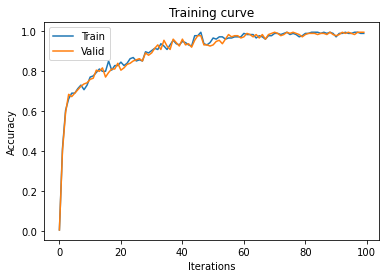

In [42]:
tiny_transformer =  caption_transformer(8)
train(tiny_transformer,tiny_train_data,tiny_train_data,learning_rate=0.001,num_epoches=100,batch_size=30,)

In [50]:
target[0][0].shape

torch.Size([51])

In [52]:

out = tiny_transformer(features[0].unsqueeze(0), target[0].unsqueeze(0)[:,:-1,:])

In [58]:
creature_imgs[0].shape

torch.Size([3, 224, 224])

'a child in a pinkkdress is climbing up a set of stairs in an entry way }@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@'

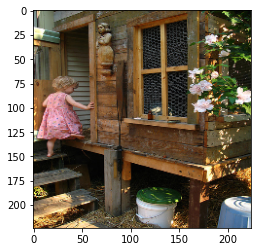

In [60]:
plt.imshow(creature_imgs[0].permute(1,2,0).int())
sentence = get_sentence_from_onehot(out,vocab)
''.join(sentence[0])

In [68]:
small_transformer = caption_transformer(8)
train(small_transformer,small_train_data,small_train_data,learning_rate=0.0001,num_epoches=1000)

Iter 1. [Val Acc 69%] [Train Acc 68%, Loss 17.605139]
Iter 2. [Val Acc 68%] [Train Acc 68%, Loss 17.586491]
Iter 3. [Val Acc 68%] [Train Acc 68%, Loss 17.544098]
Iter 4. [Val Acc 68%] [Train Acc 68%, Loss 17.527065]
Iter 5. [Val Acc 68%] [Train Acc 68%, Loss 17.494911]
Iter 6. [Val Acc 68%] [Train Acc 68%, Loss 17.470381]
Iter 7. [Val Acc 68%] [Train Acc 68%, Loss 17.449583]
Iter 8. [Val Acc 68%] [Train Acc 68%, Loss 17.461355]
Iter 9. [Val Acc 68%] [Train Acc 68%, Loss 17.441418]
Iter 10. [Val Acc 68%] [Train Acc 68%, Loss 17.425283]
Iter 11. [Val Acc 68%] [Train Acc 68%, Loss 17.418486]
Iter 12. [Val Acc 68%] [Train Acc 68%, Loss 17.386395]
Iter 13. [Val Acc 68%] [Train Acc 68%, Loss 17.385880]
Iter 14. [Val Acc 68%] [Train Acc 68%, Loss 17.362762]
Iter 15. [Val Acc 68%] [Train Acc 68%, Loss 17.339804]
Iter 16. [Val Acc 68%] [Train Acc 68%, Loss 17.317007]
Iter 17. [Val Acc 68%] [Train Acc 68%, Loss 17.323132]
Iter 18. [Val Acc 68%] [Train Acc 68%, Loss 17.321924]
Iter 19. [Val Acc 6

KeyboardInterrupt: 